In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
GAMMAS = ['1.0','0.9','0.8','0.7','0.6','0.5']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n16/"

def get_chance(gamma):
    if gamma == '1.0':
        return '100'
    elif gamma == '0.9':
        return '90'
    elif gamma == '0.8':
        return '80'
    elif gamma == '0.7':
        return '70'
    elif gamma == '0.6':
        return '60'
    elif gamma == '0.5':
        return '50'
    
def get_gamma_index(gamma):
    if gamma == '1.0':
        return 0
    elif gamma == '0.9':
        return 1
    elif gamma == '0.8':
        return 2
    elif gamma == '0.7':
        return 3
    elif gamma == '0.6':
        return 4
    elif gamma == '0.5':
        return 5
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in GAMMAS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in GAMMAS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in GAMMAS]
PLOT_X = [get_chance(p) + '%' for p in GAMMAS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))
#         print("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
#         .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in GAMMAS:
        runSketchTweets("SketchingTweet-v1_n16", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(GAMMAS)
    termfreq = [0] * len(GAMMAS)
    query_result = [0] * len(GAMMAS)
    query_similarity = [0] * len(GAMMAS)
    query_lookups = [0] * len(GAMMAS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+\.\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            gamma = filename.group(4)

            if name == "summary":    
                for p in GAMMAS:
                    if gamma == p:
                        summary[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in GAMMAS:
                    if gamma == p:
                        termfreq[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in GAMMAS:
                    if gamma == p:
                        query_result[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in GAMMAS:
                    if gamma == p:
                        query_similarity[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in GAMMAS:
                    if gamma == p:
                        query_lookups[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                  
    
    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [6]:
results = run_expm1() 

# Process Results

In [7]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [8]:
summary = results['summary']
summary

,Summary_100%,Summary_90%,Summary_80%,Summary_70%,Summary_60%,Summary_50%
Run,1,1,1,1,1,1
Chance,100.0%,90.0%,80.0%,70.0%,60.0%,50.0%
Index time unit,1000,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,21890,21890,21890,21890,21890,21890
Indexed tweet counts,197610,197610,197610,197610,197610,197610
Index size,215201,204631,194248,183612,173157,162670


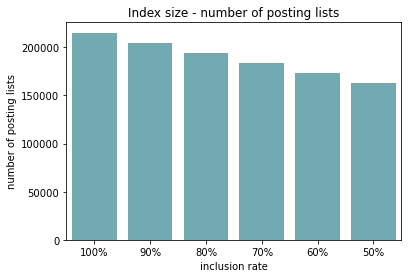

Summary_100%    215201
Summary_90%     204631
Summary_80%     194248
Summary_70%     183612
Summary_60%     173157
Summary_50%     162670
Name: Index size, dtype: object

In [9]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

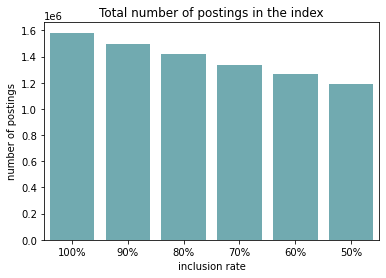

Total number of postings:


[1582263, 1496156, 1422963, 1335514, 1267295, 1188607]

In [10]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

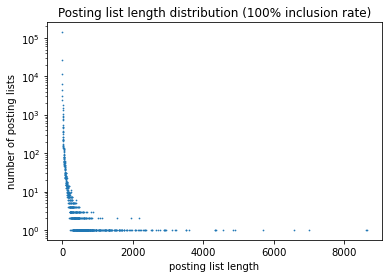

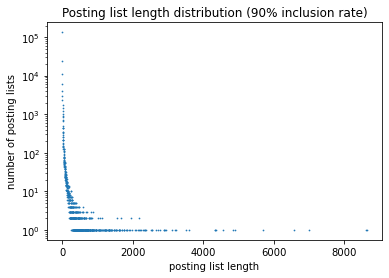

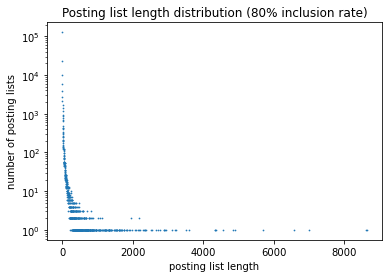

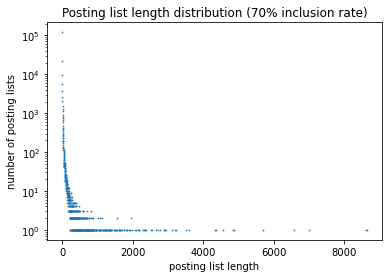

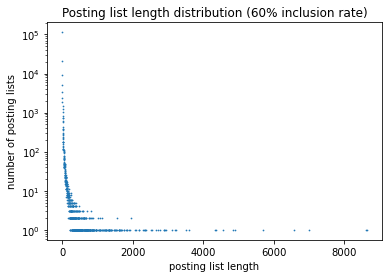

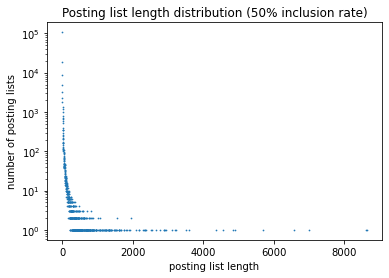

In [11]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.352489068359348, 7.311482619935396, 7.325496272805897, 7.273565997865063, 7.318762741327235, 7.306860515153378]


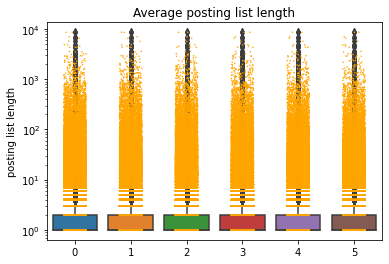

In [12]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.700,0.700,0.700,0.700,0.55556,5137,4130,4130,4130,4130,2538
1,146028,146028,146028,146028,146028,-1,0.50000,0.600,0.600,0.500,0.500,0.00000,6516,5185,5185,4128,4128,-1
2,-1,-1,-1,145908,145908,145908,0.00000,0.000,0.000,0.500,0.500,0.50000,-1,-1,-1,1584,1584,1584
3,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
21886,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
21887,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
21888,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1


In [14]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.70000,0.70000,0.70000,0.70000,0.55556,5137,4130,4130,4130,4130,2538
1,146028,146028,146028,146028,146028,-1,0.50000,0.60000,0.60000,0.50000,0.50000,0.00000,6516,5185,5185,4128,4128,-1
8,44802,44802,44802,44802,44802,44802,0.60000,0.60000,0.60000,0.60000,0.60000,0.60000,38975,38975,38975,38975,38975,38975
12,170152,170152,170152,197505,197505,197505,0.60000,0.60000,0.60000,0.50000,0.50000,0.50000,7605,7605,7605,20,20,20
15,102434,102434,102434,102434,102434,102434,0.50000,0.50000,0.50000,0.60000,0.60000,0.60000,10200,10200,10200,6940,6940,6940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,0.83333,0.60000,7,7,7,7,6,5
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,0.83333,0.60000,7,7,7,7,6,5
21881,93654,93654,93654,93654,93654,93654,0.53846,0.53846,0.53846,0.53846,0.58333,0.58333,81484,81458,81484,81471,47616,47616
21884,178680,178680,178680,178680,178680,178680,0.62500,0.57143,0.57143,0.50000,0.50000,0.50000,120,84,84,66,66,66


In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[7247, 6219, 5562, 4872, 4475, 3962]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 90% of terms, we can find 85.81% truly similar tweets
Using 80% of terms, we can find 76.75% truly similar tweets
Using 70% of terms, we can find 67.23% truly similar tweets
Using 60% of terms, we can find 61.75% truly similar tweets
Using 50% of terms, we can find 54.67% truly similar tweets


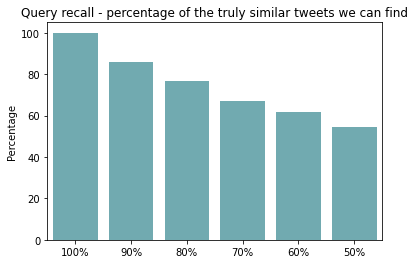

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [17]:
# is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
# predict_similar = query_result_similarity_lookup[is_predict_similar]
# num_predict_similar = predict_similar.shape[0]
# predict_similar
num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[7247, 7382, 7528, 7594, 7672, 7597]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 90% of terms, 84.25% tweets that we found similar are truly similar tweets
Using 80% of terms, 73.88% tweets that we found similar are truly similar tweets
Using 70% of terms, 64.16% tweets that we found similar are truly similar tweets
Using 60% of terms, 58.33% tweets that we found similar are truly similar tweets
Using 50% of terms, 52.15% tweets that we found similar are truly similar tweets


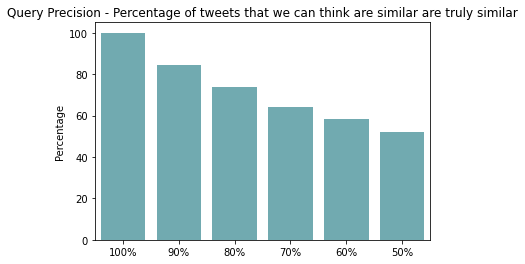

In [18]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [19]:
correct_search

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.70000,0.70000,0.70000,0.70000,0.55556,5137,4130,4130,4130,4130,2538
8,44802,44802,44802,44802,44802,44802,0.60000,0.60000,0.60000,0.60000,0.60000,0.60000,38975,38975,38975,38975,38975,38975
15,102434,102434,102434,102434,102434,102434,0.50000,0.50000,0.50000,0.60000,0.60000,0.60000,10200,10200,10200,6940,6940,6940
34,193795,193795,193795,193795,193795,193795,0.60000,0.50000,0.50000,0.50000,0.50000,0.50000,365,112,112,112,112,112
40,708,708,708,708,708,708,1.00000,1.00000,1.00000,1.00000,1.00000,0.80000,12438,12438,12438,12438,12438,9260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,0.83333,0.60000,7,7,7,7,6,5
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,0.83333,0.60000,7,7,7,7,6,5
21881,93654,93654,93654,93654,93654,93654,0.53846,0.53846,0.53846,0.53846,0.58333,0.58333,81484,81458,81484,81471,47616,47616
21884,178680,178680,178680,178680,178680,178680,0.62500,0.57143,0.57143,0.50000,0.50000,0.50000,120,84,84,66,66,66


In [20]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 1941, 2340, 2662, 2811, 2788]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 90% of terms, 31.21% queries need less lookups before correctly finding the true similar tweets
Using 80% of terms, 42.07% queries need less lookups before correctly finding the true similar tweets
Using 70% of terms, 54.64% queries need less lookups before correctly finding the true similar tweets
Using 60% of terms, 62.82% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 70.37% queries need less lookups before correctly finding the true similar tweets


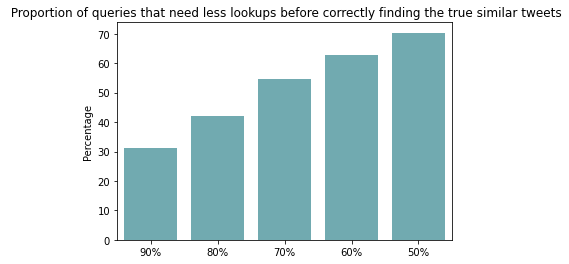

In [21]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

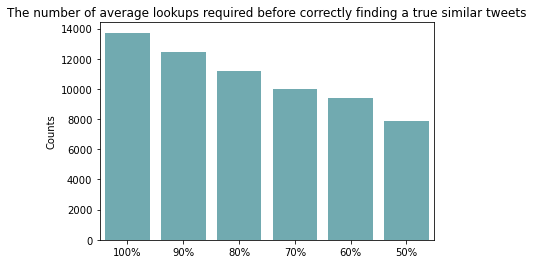

In [22]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [23]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 90% of terms, 9.5% of less lookups are needed for correctly finding a true similar tweets
By using 80% of terms, 18.26% of less lookups are needed for correctly finding a true similar tweets
By using 70% of terms, 27.18% of less lookups are needed for correctly finding a true similar tweets
By using 60% of terms, 31.54% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 42.58% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [24]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_90%,Index_time_run2_90%,Index_time_run3_90%,Index_time_run1_80%,Index_time_run2_80%,Index_time_run3_80%,Index_time_run1_70%,Index_time_run2_70%,Index_time_run3_70%,Index_time_run1_60%,Index_time_run2_60%,Index_time_run3_60%,Index_time_run1_50%,Index_time_run2_50%,Index_time_run3_50%
0,13.1757,11.0935,11.8053,18.4591,15.7826,15.9551,18.3812,16.6408,24.6686,17.6462,20.4564,17.2021,18.0317,16.5506,15.4373,18.2906,21.0784,15.9914
1,5.4348,6.4041,4.9464,6.2269,6.4794,6.6513,6.9130,7.4667,10.3307,7.8187,6.6240,7.2895,6.4939,8.9833,6.2814,6.9919,6.6255,6.2177
2,4.9395,7.6054,4.5353,6.2156,6.4274,7.2640,6.5677,7.3860,9.6338,6.4999,6.0525,6.3616,7.1751,9.7445,6.2109,6.1620,6.4665,6.7804
3,5.1099,7.5493,4.6462,6.1122,6.0236,6.5778,5.8922,6.3468,8.7068,5.5741,6.0409,6.1404,5.9054,6.3601,5.6278,5.8331,6.3856,5.7964
4,6.4880,4.8719,4.4976,6.5985,5.6349,7.0950,6.6294,7.6088,7.5290,6.3525,6.1303,5.9932,7.4426,6.4586,5.4911,5.5656,6.3038,5.2490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1.9479,2.0054,2.2642,4.0351,4.4164,3.5052,4.4033,4.6225,3.9038,30.3689,5.0197,3.6504,3.7447,4.4825,3.6158,4.7232,3.9956,4.3295
193,1.9069,1.9543,2.1875,4.0475,4.2141,3.5286,4.0673,4.8914,4.1237,3.6814,4.2968,3.7842,3.7487,30.1274,3.5753,3.7314,4.1853,3.6762
194,2.1124,2.0373,2.3136,4.0519,4.8406,3.9553,4.6697,4.3354,3.9304,4.0728,4.3483,4.5206,4.0918,5.1919,3.5390,3.9835,4.9701,3.8295
195,2.4190,2.2191,2.2163,3.7100,6.4295,4.0746,4.0306,3.9344,3.6908,3.9681,4.2228,4.1889,19.0497,4.5183,3.5194,3.8563,4.8332,3.6778


By using 100% of terms, the average time for indexing 1000 tweets is 3.2431 milliseconds
By using 90% of terms, the average time for indexing 1000 tweets is 4.2373 milliseconds
By using 80% of terms, the average time for indexing 1000 tweets is 4.3777 milliseconds
By using 70% of terms, the average time for indexing 1000 tweets is 4.2083 milliseconds
By using 60% of terms, the average time for indexing 1000 tweets is 4.1753 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 4.0499 milliseconds


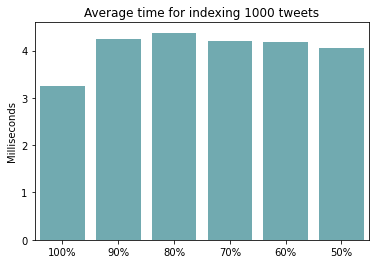

In [25]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [26]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_90%,Query_time_run2_90%,Query_time_run3_90%,Query_time_run1_80%,Query_time_run2_80%,Query_time_run3_80%,Query_time_run1_70%,Query_time_run2_70%,Query_time_run3_70%,Query_time_run1_60%,Query_time_run2_60%,Query_time_run3_60%,Query_time_run1_50%,Query_time_run2_50%,Query_time_run3_50%
0,2.5982,3.0780,2.1923,2.2403,2.2751,2.1229,2.1406,2.3035,2.1144,2.5034,2.6348,3.0988,2.7212,2.3071,2.9163,1.9377,3.0433,2.6039
1,284.8341,306.7222,293.8342,307.4182,379.7453,295.7391,237.3942,303.9545,267.8507,222.2917,222.5732,249.6709,198.1671,208.1108,257.7951,190.3342,205.7169,197.1511
2,180.1903,197.2440,194.7051,201.3051,233.2500,183.5675,160.1014,173.0729,156.0980,119.3869,127.2462,120.3259,105.0700,114.6220,146.9616,93.9691,78.3696,96.9567
3,183.3137,247.9218,204.3946,198.9512,192.2292,185.4348,164.3824,177.3390,161.4879,121.5380,124.1071,121.7189,106.6947,129.0899,105.4457,96.9492,80.7353,101.4494
4,195.2632,199.7676,204.3025,205.0735,204.5688,184.9490,170.1081,170.0972,164.1849,129.5871,131.7277,126.4050,110.5576,110.2553,109.4303,99.0410,87.5001,128.8240
5,175.8388,191.2386,203.3342,202.3100,168.4616,198.6736,173.2490,177.2735,169.6490,130.7509,134.0740,131.4505,118.7088,113.8712,110.4241,109.4324,91.8626,109.5191
6,175.1232,188.0059,206.2411,187.6730,154.0405,195.0759,166.2147,157.0942,171.2494,134.4851,144.2183,117.4325,111.6119,110.7212,105.2190,103.5832,94.4174,118.9863
7,193.6853,191.3017,210.8103,200.4468,166.3290,219.7203,177.5274,160.5766,177.0699,131.1989,138.9854,131.5964,113.6859,118.1867,114.3315,114.2552,95.1544,132.4947
8,190.1328,191.9889,207.2150,203.4701,191.4696,202.9132,169.3304,159.6296,166.4754,123.3112,121.5760,125.9725,111.2627,112.5541,109.4760,106.5399,93.8142,107.4173
9,176.2943,191.3263,191.0257,186.5941,155.9065,184.0442,162.9575,172.7409,158.8327,118.8049,119.8233,120.8909,108.2865,105.9316,108.2295,106.6311,93.8046,120.7387


By using 100% of terms, the average time for querying 1000 tweets is 181.1989 milliseconds
By using 90% of terms, the average time for querying 1000 tweets is 178.4371 milliseconds
By using 80% of terms, the average time for querying 1000 tweets is 154.7791 milliseconds
By using 70% of terms, the average time for querying 1000 tweets is 117.8154 milliseconds
By using 60% of terms, the average time for querying 1000 tweets is 103.7115 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 93.8753 milliseconds


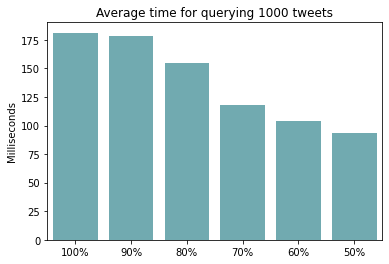

In [27]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))